# Scenario Generation and KSS Analysis

This notebook generates light exposure scenarios with a maximum of 250 lux (0.27329575 melanopic irradiance) lasting 3 hours, using pulses, sustained, or combinations. Outside these 3 hours, 50 lux (0.05465915 melanopic irradiance) is used during the day, and 0 lux (0 melanopic irradiance) is used at night (10 PM to 6 AM).

For each scenario, the model is run and KSS values are calculated. The delta between the initial and final KSS values (after 3 hours) is computed. Scenarios with similar KSS delta (< 0.1) are identified, and their irradiance and KSS curves are plotted on adjacent plots.

> EML * 0.91 * 1.2013e-3 = melanopic irradiance (W/m^2)
> EML * 0.91 = MEDI
> MEDI * 1.2013e-3 = melanopic irradiance (W/m^2)

In [1]:
import constants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import models

def is_night(hour):
    return hour < 6 or hour >= 22

dKSS = -1.1

In [2]:
# Optimzation for constant scenario (1)
def constant(max):
    DAY_IRRADIANCE = 0.02186366 # 0.05465915
    NIGHT_IRRADIANCE = 0.0

    minutes_per_day = 24 * 60
    total_minutes = minutes_per_day
    time_points = np.arange(0, total_minutes)
    hours = time_points / 60
    start_hour=12.5
    duration=3

    irradiance = []
    for h in hours:
        if h < 6 or h >= 22:
            irradiance.append(NIGHT_IRRADIANCE)
        elif start_hour <= h < start_hour + duration:
            irradiance.append(max)
        else:
            irradiance.append(DAY_IRRADIANCE)
    
    interpolator = lambda t: np.interp(t/3600, hours, np.array(irradiance))
    sol, t = models.model_run(1, len(hours), interpolator=interpolator, waketime=6, bedtime=22, debug=False)
    X = sol[:, 3]
    Y = sol[:, 4]
    H = sol[:, 2]
    Theta_L = sol[:, 6]
    C = models.circadian_drive_v(X, Y)
    KSS = models.alertness_measure_v(C, H, Theta_L)
    start_idx = int(start_hour * 60)
    end_idx = int((start_hour + 3) * 60)
    return KSS[end_idx] - KSS[start_idx]

from scipy.optimize import brentq

def find_max_for_delta_kss(target_delta=-0.8, lower=0.0, upper=0.8):
    # Define the function whose root we want to find
    def func(max_val):
        return constant(max_val) - target_delta
    # Use brentq to find the root
    result = brentq(func, lower, upper)
    return result

max_value = find_max_for_delta_kss(dKSS)
print(f"Max irradiance for delta KSS: {max_value:.4f}")
print(f"Delta KSS = {constant(max_value):.4f}")

s1_max = max_value

Max irradiance for delta KSS: 0.3228
Delta KSS = -1.1000


In [3]:
def pulses(max, pulse_length_min, interval_min):
    DAY_IRRADIANCE = 0.02186366
    NIGHT_IRRADIANCE = 0.0

    minutes_per_day = 24 * 60
    total_minutes = minutes_per_day
    time_points = np.arange(0, total_minutes)
    hours = time_points / 60
    start_hour=12.5
    duration=3

    irradiance = []
    pulse_start = start_hour * 60
    pulse_end = (start_hour + duration) * 60
    for i, h in enumerate(hours):
        minute = int(h * 60)
        if is_night(h):
            irradiance.append(NIGHT_IRRADIANCE)
        elif pulse_start <= minute < pulse_end:
            # Calculate if current minute is within a pulse
            cycle = (minute - pulse_start) // (pulse_length_min + interval_min)
            cycle_start = pulse_start + cycle * (pulse_length_min + interval_min)
            if cycle_start <= minute < cycle_start + pulse_length_min:
                irradiance.append(max)
            else:
                irradiance.append(DAY_IRRADIANCE)
        else:
            irradiance.append(DAY_IRRADIANCE)
    
    interpolator = lambda t: np.interp(t/3600, hours, np.array(irradiance))
    sol, t = models.model_run(1, len(hours), interpolator=interpolator, waketime=6, bedtime=22, debug=False)
    X = sol[:, 3]
    Y = sol[:, 4]
    H = sol[:, 2]
    Theta_L = sol[:, 6]
    C = models.circadian_drive_v(X, Y)
    KSS = models.alertness_measure_v(C, H, Theta_L)
    start_idx = int(start_hour * 60)
    end_idx = int((start_hour + 3) * 60)
    return KSS[end_idx] - KSS[start_idx]

from scipy.optimize import minimize

def objective(params, target_delta):
    max_val, pulse_length_min, interval_min = params
    delta = pulses(max_val, pulse_length_min, interval_min)
    print(f"params={params}, delta={delta}, opt={abs(delta - target_delta)}")
    return abs(delta - target_delta) 

x0 = [0.3, 1, 1]
target_delta = dKSS

result = minimize(objective, x0, args=(target_delta,), bounds=[(0, 0.3), (0.5, 30), (0.5, 30)], method='Powell')
if result.success:
    max_val, pulse_length_min, interval_min = result.x
    print(f"Optimized parameters for delta KSS = {target_delta}:")
    print(f"max = {max_val:.4f}, pulse_length_min = {pulse_length_min:.2f}, interval_min = {interval_min:.2f}")
    print(f"delta_KSS = {pulses(max_val, pulse_length_min, interval_min):.4f}")
else:
    print("Optimization failed:", result.message)

# max = 0.1788, pulse_length_min = 2.25, interval_min = 4.36
# delta_KSS = -0.6077220708416582

params=[0.3 1.  1. ], delta=-0.08900802197704305, opt=1.010991978022957
params=[0.1145898 1.        1.       ], delta=-0.031968079162118634, opt=1.0680319208378815
params=[0.1854102 1.        1.       ], delta=-0.0352037278628794, opt=1.0647962721371207
params=[0.22917961 1.         1.        ], delta=-0.03826791573806965, opt=1.0617320842619304
params=[0.25623059 1.         1.        ], delta=-0.04365778305822854, opt=1.0563422169417716
params=[0.27294902 1.         1.        ], delta=-0.05236730353259578, opt=1.0476326964674043
params=[0.28328157 1.         1.        ], delta=-0.06217510550659977, opt=1.0378248944934003
params=[0.28966744 1.         1.        ], delta=-0.07066779093562481, opt=1.0293322090643753


KeyboardInterrupt: 

In [4]:
def pulses_30(max, pulse_length_min):
    DAY_IRRADIANCE = 0.02186366
    NIGHT_IRRADIANCE = 0.0

    minutes_per_day = 24 * 60
    total_minutes = minutes_per_day
    time_points = np.arange(0, total_minutes)
    hours = time_points / 60
    start_hour=12.5
    duration=3
    interval_min=30

    irradiance = []
    pulse_start = start_hour * 60
    pulse_end = (start_hour + duration) * 60
    for i, h in enumerate(hours):
        minute = int(h * 60)
        if is_night(h):
            irradiance.append(NIGHT_IRRADIANCE)
        elif pulse_start <= minute < pulse_end:
            # Calculate if current minute is within a pulse
            cycle = (minute - pulse_start) // (pulse_length_min + interval_min)
            cycle_start = pulse_start + cycle * (pulse_length_min + interval_min)
            if cycle_start <= minute < cycle_start + pulse_length_min:
                irradiance.append(max)
            else:
                irradiance.append(DAY_IRRADIANCE)
        else:
            irradiance.append(DAY_IRRADIANCE)
    
    interpolator = lambda t: np.interp(t/3600, hours, np.array(irradiance))
    sol, t = models.model_run(1, len(hours), interpolator=interpolator, waketime=6, bedtime=22, debug=False)
    X = sol[:, 3]
    Y = sol[:, 4]
    H = sol[:, 2]
    Theta_L = sol[:, 6]
    C = models.circadian_drive_v(X, Y)
    KSS = models.alertness_measure_v(C, H, Theta_L)
    start_idx = int(start_hour * 60)
    end_idx = int((start_hour + 3) * 60)
    return KSS[end_idx] - KSS[start_idx]

from scipy.optimize import minimize

def objective(params, target_delta):
    max_val, pulse_length_min = params
    delta = pulses_30(max_val, pulse_length_min)
    print(f"params={params}, delta={delta}, opt={abs(delta - target_delta)}")
    return abs(delta - target_delta) 

x0 = [0.1, 40]
target_delta = dKSS

result = minimize(objective, x0, args=(target_delta,), bounds=[(0, 1.0), (10, 60)], method='Powell')
if result.success:
    max_val, pulse_length_min = result.x
    print(f"Optimized parameters for delta KSS = {target_delta}:")
    print(f"max = {max_val:.4f}, pulse_length_min = {pulse_length_min:.2f}, interval_min = {30:.2f}")
    print(f"delta_KSS = {pulses_30(max_val, pulse_length_min):.4f}")
else:
    print("Optimization failed:", result.message)

s3_max = max_val
s3_length_min = pulse_length_min

# max = 0.0929, pulse_length_min = 26.67, interval_min = 30.00
# delta_KSS = -0.6020513139859824

params=[ 0.1 40. ], delta=-0.03262035525002904, opt=1.067379644749971
params=[ 0.38196601 40.        ], delta=-1.1470566345616948, opt=0.04705663456169473
params=[ 0.61803399 40.        ], delta=-1.1665262669842362, opt=0.06652626698423614
params=[ 0.23606798 40.        ], delta=-0.06150927058674682, opt=1.0384907294132533
params=[ 0.49770986 40.        ], delta=-1.1611740278389102, opt=0.06117402783891013
params=[ 0.32623792 40.        ], delta=-0.9693850972752598, opt=0.1306149027247403
params=[ 0.42617623 40.        ], delta=-1.1564576367615467, opt=0.05645763676154658
params=[ 0.36067977 40.        ], delta=-1.1274299603730649, opt=0.027429960373064777
params=[ 0.34752416 40.        ], delta=-1.09669154670831, opt=0.00330845329169005
params=[ 0.33939354 40.        ], delta=-1.0630805634238216, opt=0.036919436576178466
params=[ 0.35083176 40.        ], delta=-1.1066553684335894, opt=0.0066553684335892704
params=[ 0.34441854 40.        ], delta=-1.0855419717826633, opt=0.014458028217

In [ ]:
# add one peak scenario

In [5]:
# Optimization for daylight scenario (4)
daytime_df = pd.read_csv('./data/daytime_irradiance_curve.csv')
daytime_df = daytime_df[(daytime_df['time'] >= 8.5) & (daytime_df['time'] <= 18)]
time = daytime_df['time'].values
time = np.linspace(12.5, 15.5, len(time))  # 12:30 to 15:30 in hours
daytime_irradiance = daytime_df['irradiance'].values / constants.CONVERSION_FACTOR
daytime_interpolator = lambda t: np.interp(t, time, np.array(daytime_irradiance))

def daylight(max):
    DAY_IRRADIANCE = 0.02186366
    NIGHT_IRRADIANCE = 0.0

    minutes_per_day = 24 * 60
    total_minutes = minutes_per_day
    time_points = np.arange(0, total_minutes)
    hours = time_points / 60
    start_hour=12.5
    duration=3

    irradiance = []
    for h in hours:
        if h < 6 or h >= 22:
            irradiance.append(NIGHT_IRRADIANCE)
        elif start_hour <= h < start_hour + duration:
            irradiance.append(max*daytime_interpolator(h))
        else:
            irradiance.append(DAY_IRRADIANCE)
    
    interpolator = lambda t: np.interp(t/3600, hours, np.array(irradiance))
    sol, t = models.model_run(1, len(hours), interpolator=interpolator, waketime=6, bedtime=22, debug=False)
    X = sol[:, 3]
    Y = sol[:, 4]
    H = sol[:, 2]
    Theta_L = sol[:, 6]
    C = models.circadian_drive_v(X, Y)
    KSS = models.alertness_measure_v(C, H, Theta_L)
    start_idx = int(start_hour * 60)
    end_idx = int((start_hour + 3) * 60)
    return KSS[end_idx] - KSS[start_idx]

from scipy.optimize import brentq

def find_max_for_delta_kss_daylight(target_delta=-1.1, lower=0.0, upper=10.0):
    def func(max_val):
        return daylight(max_val) - target_delta
    result = brentq(func, lower, upper)
    return result

max_value = find_max_for_delta_kss_daylight(dKSS)
print(f"Max for delta KSS: {max_value:.4f}")
print(f"delta_KSS = {daylight(max_value):.4f}")

s4_max = max_value

Max for delta KSS: 4.2112
delta_KSS = -1.1000


In [20]:
import numpy as np
from scipy.optimize import brentq

def triangle_scenario(max_peak, start_hour=12.5, duration=3):
    DAY_IRRADIANCE = 0.02186366
    NIGHT_IRRADIANCE = 0.0
    minutes_per_day = 24 * 60
    hours = np.arange(0, minutes_per_day) / 60
    midpoint = start_hour + duration / 2

    irradiance = []
    for h in hours:
        if h < 6 or h >= 22:
            irradiance.append(NIGHT_IRRADIANCE)
        elif start_hour <= h < start_hour + duration:
            # Triangle: ramp up, then down
            if h <= midpoint:
                val = DAY_IRRADIANCE + (max_peak - DAY_IRRADIANCE) * ((h - start_hour) / (midpoint - start_hour))
            else:
                val = DAY_IRRADIANCE + (max_peak - DAY_IRRADIANCE) * ((start_hour + duration - h) / (midpoint - start_hour))
            irradiance.append(val)
        else:
            irradiance.append(DAY_IRRADIANCE)
    return np.array(irradiance)

def triangle_delta_kss(max_peak):
    irradiance = triangle_scenario(max_peak)
    hours = np.arange(0, 24*60) / 60
    interpolator = lambda t: np.interp(t/3600, hours, irradiance)
    sol, t = models.model_run(1, len(hours), interpolator=interpolator, waketime=6, bedtime=22, debug=False)
    X = sol[:, 3]
    Y = sol[:, 4]
    H = sol[:, 2]
    Theta_L = sol[:, 6]
    C = models.circadian_drive_v(X, Y)
    KSS = models.alertness_measure_v(C, H, Theta_L)
    start_idx = int(12.5 * 60)
    end_idx = int((12.5 + 3) * 60)
    return KSS[end_idx] - KSS[start_idx]

def find_peak_for_delta_kss(target_delta=-1.1, lower=0.0, upper=4.0):
    def func(max_peak):
        return triangle_delta_kss(max_peak) - target_delta
    result = brentq(func, lower, upper)
    return result

# Example usage:
peak_value = find_peak_for_delta_kss(dKSS)
print(f"Peak irradiance for delta KSS: {peak_value:.4f}")
print(f"delta_KSS = {triangle_delta_kss(peak_value):.4f}")

s5_max = peak_value

Peak irradiance for delta KSS: 3.6109
delta_KSS = -1.1000


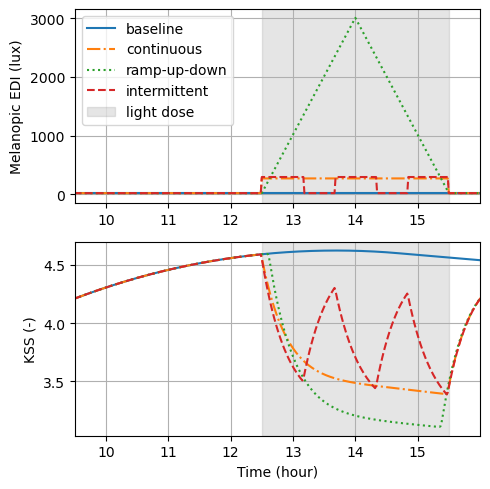

In [21]:
import constants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import models

def is_night(hour):
    return hour < 6 or hour >= 22

# Control
DAY_IRRADIANCE = 0.02186366 # 0.05465915
NIGHT_IRRADIANCE = 0.0

minutes_per_day = 24 * 60
total_minutes = minutes_per_day
time_points = np.arange(0, total_minutes)
hours = time_points / 60
start_hour=12.5
duration=3

irradianceC = []
for h in hours:
    if h < 6 or h >= 22:
        irradianceC.append(NIGHT_IRRADIANCE)
    else:
        irradianceC.append(DAY_IRRADIANCE)

interpolator = lambda t: np.interp(t/3600, hours, np.array(irradianceC))
sol, t = models.model_run(1, len(hours), interpolator=interpolator, waketime=6, bedtime=22, debug=False)
X = sol[:, 3]
Y = sol[:, 4]
H = sol[:, 2]
Theta_L = sol[:, 6]
C = models.circadian_drive_v(X, Y)
KSSC = models.alertness_measure_v(C, H, Theta_L)

# Scenario 1
DAY_IRRADIANCE = 0.02186366 # 0.05465915
NIGHT_IRRADIANCE = 0.0

minutes_per_day = 24 * 60
total_minutes = minutes_per_day
time_points = np.arange(0, total_minutes)
hours = time_points / 60
start_hour=12.5
duration=3

irradiance1 = []
for h in hours:
    if h < 6 or h >= 22:
        irradiance1.append(NIGHT_IRRADIANCE)
    elif start_hour <= h < start_hour + duration:
        irradiance1.append(s1_max)
    else:
        irradiance1.append(DAY_IRRADIANCE)

interpolator = lambda t: np.interp(t/3600, hours, np.array(irradiance1))
sol, t = models.model_run(1, len(hours), interpolator=interpolator, waketime=6, bedtime=22, debug=False)
X = sol[:, 3]
Y = sol[:, 4]
H = sol[:, 2]
Theta_L = sol[:, 6]
C = models.circadian_drive_v(X, Y)
KSS1 = models.alertness_measure_v(C, H, Theta_L)

# Scenario 2
DAY_IRRADIANCE = 0.02186366
NIGHT_IRRADIANCE = 0.0

minutes_per_day = 24 * 60
total_minutes = minutes_per_day
time_points = np.arange(0, total_minutes)
hours = time_points / 60
start_hour=12.5
duration=3

irradiance2 = []
pulse_start = start_hour * 60
pulse_end = (start_hour + duration) * 60
for i, h in enumerate(hours):
    minute = int(h * 60)
    if is_night(h):
        irradiance2.append(NIGHT_IRRADIANCE)
    elif pulse_start <= minute < pulse_end:
        # Calculate if current minute is within a pulse
        cycle = (minute - pulse_start) // (2.25 + 4.36)
        cycle_start = pulse_start + cycle * (2.25 + 4.36)
        if cycle_start <= minute < cycle_start + 2.25:
            irradiance2.append(0.1788)
        else:
            irradiance2.append(DAY_IRRADIANCE)
    else:
        irradiance2.append(DAY_IRRADIANCE)

interpolator = lambda t: np.interp(t/3600, hours, np.array(irradiance2))
sol, t = models.model_run(1, len(hours), interpolator=interpolator, waketime=6, bedtime=22, debug=False)
X = sol[:, 3]
Y = sol[:, 4]
H = sol[:, 2]
Theta_L = sol[:, 6]
C = models.circadian_drive_v(X, Y)
KSS2 = models.alertness_measure_v(C, H, Theta_L)

# Scenario 3
DAY_IRRADIANCE = 0.02186366
NIGHT_IRRADIANCE = 0.0

minutes_per_day = 24 * 60
total_minutes = minutes_per_day
time_points = np.arange(0, total_minutes)
hours = time_points / 60
start_hour=12.5
duration=3
interval_min=30

irradiance3 = []
pulse_start = start_hour * 60
pulse_end = (start_hour + duration) * 60
for i, h in enumerate(hours):
    minute = int(h * 60)
    if is_night(h):
        irradiance3.append(NIGHT_IRRADIANCE)
    elif pulse_start <= minute < pulse_end:
        # Calculate if current minute is within a pulse
        cycle = (minute - pulse_start) // (s3_length_min + interval_min)
        cycle_start = pulse_start + cycle * (s3_length_min + interval_min)
        if cycle_start <= minute < cycle_start + s3_length_min:
            irradiance3.append(s3_max)
        else:
            irradiance3.append(DAY_IRRADIANCE)
    else:
        irradiance3.append(DAY_IRRADIANCE)

interpolator = lambda t: np.interp(t/3600, hours, np.array(irradiance3))
sol, t = models.model_run(1, len(hours), interpolator=interpolator, waketime=6, bedtime=22, debug=False)
X = sol[:, 3]
Y = sol[:, 4]
H = sol[:, 2]
Theta_L = sol[:, 6]
C = models.circadian_drive_v(X, Y)
KSS3 = models.alertness_measure_v(C, H, Theta_L)

# Scenario 4
daytime_df = pd.read_csv('./data/daytime_irradiance_curve.csv')
daytime_df = daytime_df[(daytime_df['time'] >= 8.5) & (daytime_df['time'] <= 18)]
time = daytime_df['time'].values
time = np.linspace(12.5, 15.5, len(time))  # 12:30 to 15:30 in hours
daytime_irradiance = daytime_df['irradiance'].values / constants.CONVERSION_FACTOR
daytime_interpolator = lambda t: np.interp(t, time, np.array(daytime_irradiance))

DAY_IRRADIANCE = 0.02186366
NIGHT_IRRADIANCE = 0.0

minutes_per_day = 24 * 60
total_minutes = minutes_per_day
time_points = np.arange(0, total_minutes)
hours = time_points / 60
start_hour=12.5
duration=3

irradiance4 = []
for h in hours:
    if h < 6 or h >= 22:
        irradiance4.append(NIGHT_IRRADIANCE)
    elif start_hour <= h < start_hour + duration:
        irradiance4.append(s4_max*daytime_interpolator(h))
    else:
        irradiance4.append(DAY_IRRADIANCE)

interpolator = lambda t: np.interp(t/3600, hours, np.array(irradiance4))
sol, t = models.model_run(1, len(hours), interpolator=interpolator, waketime=6, bedtime=22, debug=False)
X = sol[:, 3]
Y = sol[:, 4]
H = sol[:, 2]
Theta_L = sol[:, 6]
C = models.circadian_drive_v(X, Y)
KSS4 = models.alertness_measure_v(C, H, Theta_L)

# Scenario 5
DAY_IRRADIANCE = 0.02186366
NIGHT_IRRADIANCE = 0.0
minutes_per_day = 24 * 60
hours = np.arange(0, minutes_per_day) / 60
midpoint = start_hour + duration / 2

irradiance5 = []
for h in hours:
    if h < 6 or h >= 22:
        irradiance5.append(NIGHT_IRRADIANCE)
    elif start_hour <= h < start_hour + duration:
        # Triangle: ramp up, then down
        if h <= midpoint:
            val = DAY_IRRADIANCE + (s5_max - DAY_IRRADIANCE) * ((h - start_hour) / (midpoint - start_hour))
        else:
            val = DAY_IRRADIANCE + (s5_max - DAY_IRRADIANCE) * ((start_hour + duration - h) / (midpoint - start_hour))
        irradiance5.append(val)
    else:
        irradiance5.append(DAY_IRRADIANCE)

hours = np.arange(0, 24*60) / 60
interpolator = lambda t: np.interp(t/3600, hours, irradiance5)
sol, t = models.model_run(1, len(hours), interpolator=interpolator, waketime=6, bedtime=22, debug=False)
X = sol[:, 3]
Y = sol[:, 4]
H = sol[:, 2]
Theta_L = sol[:, 6]
C = models.circadian_drive_v(X, Y)
KSS5 = models.alertness_measure_v(C, H, Theta_L)

import matplotlib.patches as mpatches

# Plotting the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5))

# TODO: grey out the 12.5-15.5 area and write "light dose"
# TODO: cram plots but has to be legible
# TODO: test print in black and white

for ax in [ax1, ax2]:
    ax.axvspan(12.5, 15.5, color='gray', alpha=0.2, zorder=0)

light_dose_patch = mpatches.Patch(color='gray', alpha=0.2, label='light dose')

# Irradiance plot
ax1.plot(hours, np.array(irradianceC)/1.2013e-3, label="baseline", linestyle="-")
ax1.plot(hours, np.array(irradiance1)/1.2013e-3, label="continuous", linestyle="-.")
ax1.plot(hours, np.array(irradiance5)/1.2013e-3, label="ramp-up-down", linestyle=":")
ax1.plot(hours, np.array(irradiance3)/1.2013e-3, label="intermittent", linestyle="--")
ax1.set_ylabel("Melanopic EDI (lux)")
ax1.set_xlim(9.5, 16)
ax1.set_xticks(np.arange(10, 16, 1))
handles, labels = ax1.get_legend_handles_labels()
handles.append(light_dose_patch)
labels.append("light dose")
ax1.legend(handles, labels)
ax1.grid(True)

# KSS plot
ax2.plot(hours, np.array(KSSC), label="baseline", linestyle="-")
ax2.plot(hours, np.array(KSS1), label="continuous", linestyle="-.")
ax2.plot(hours, np.array(KSS5), label="ramp-up-down", linestyle=":")
ax2.plot(hours, np.array(KSS3), label="intermittent", linestyle="--")
ax2.set_xlabel("Time (hour)")
ax2.set_ylabel("KSS (-)")
ax2.set_xlim(9.5, 16)
ax2.set_xticks(np.arange(10, 16, 1))
ax2.grid(True)

plt.tight_layout()
plt.show()